In [1]:
import os
os.chdir(os.path.join(os.getcwd(), '..'))

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

2023-12-01 12:51:28.442347: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 12:51:28.442435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 12:51:28.466355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 12:51:28.520661: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-01 12:51:29.516373: W tensorflow/compiler/tf2

scanpy==1.9.6 anndata==0.10.3 umap==0.5.4 numpy==1.26.1 scipy==1.11.3 pandas==1.5.3 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.10


## 0. Reading data into AnnData object

Since we are working with the PBMC-3k dataset and the data is encoded in .mtx format, we use `.read_10x_mtx` to read the data and load it to a AnnData object. The function asks for the path of the folder containing the .mtx file (not the path of the file) and the names we want to use for the genes (variables). By default it uses symbols but we can also call it with 'gene_ids'.

In [53]:
data_path = '/media/user/T7 Touch/PhD_Lucas/rna_sequencing/data/external/pbmc68k/'  # the directory with the `.mtx` file
results_file = 'write/pbmc68k.h5ad'      # the file that will store the analysis results

adataCopy = sc.read_10x_mtx(
    path = data_path,            # the directory with the `.mtx` file
    var_names = 'gene_symbols',  # use gene symbols for the variable names (variables-axis index)
    cache = True)    

... reading from cache file cache/media-user-T7 Touch-PhD_Lucas-rna_sequencing-data-external-pbmc68k-matrix.h5ad


/home/user/lucas-dev/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


By calling the AnnData object we can see that we have 5898240 cells (observations) and 32738 genes (variables). In this case all the variables have a unique name (identifier) but in case that we get a warning, we can call `.var_names_make_unique()` to make all the variables names unique.

In [54]:
adataCopy

AnnData object with n_obs × n_vars = 5898240 × 32738
    var: 'gene_ids'

Names of cells and genes can be accesed by calling `.obs_names` and `.var_names` respectively.

## 1. Adding annotations

We also have the annotations for ~68k cells where they class each cells in one out of 11 cell groups. To do so, we can read the .tsv file and sicne both the annotations and the `.obs` are dataframes, we can merge then by keys.

In [55]:
import pandas as pd

anno = pd.read_csv('data/external/pbmc68k/annotations.tsv', sep='\t')
anno.head()

,TSNE.1,TSNE.2,barcodes,celltype
0,7.565540,0.441370,AAACATACACCCAA-1,CD8+ Cytotoxic T
1,2.552626,-25.786672,AAACATACCCCTCA-1,CD8+/CD45RA+ Naive Cytotoxic
2,-5.771831,11.830846,AAACATACCGGAGA-1,CD4+/CD45RO+ Memory
3,1.762556,25.979346,AAACATACTAACCG-1,CD19+ B
4,-16.793856,-16.589970,AAACATACTCTTCA-1,CD4+/CD25 T Reg


We can see that the 'barcodes' column corresponds to the name of the cells. In order to not modify the original dataset (just in case we want to manipulate it later) we can make a copy of the AnnData object. We add a new column to the cells dataframe (obs) adding the values of the merged dataframe and lastly we drop all the cells that have NaN values (in the celltype column).

In [56]:
adata = adataCopy.copy()
inner = pd.merge(adata.obs, anno, left_index=True, right_on='barcodes', how='left')
adata.obs['celltype'] = inner['celltype'].values
idx = np.where(adata.obs['celltype'].notna())[0]
adata = adata[idx, :]

## 2. Preprocessing

One of the previous steps before analysing the data is to treat it so that the statisticals computations make more sense. In this case, we know that scRNA-seaquencing suffers from the so called 'curse of dimensionalty'. Even though we tend to think that the more features (genes) the best to classify the observations, it is not always true. This often happens in this field where the number of variables is too high, so that there are many of them that don't actually add information, but rather noise.

/home/user/lucas-dev/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/home/user/lucas-dev/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


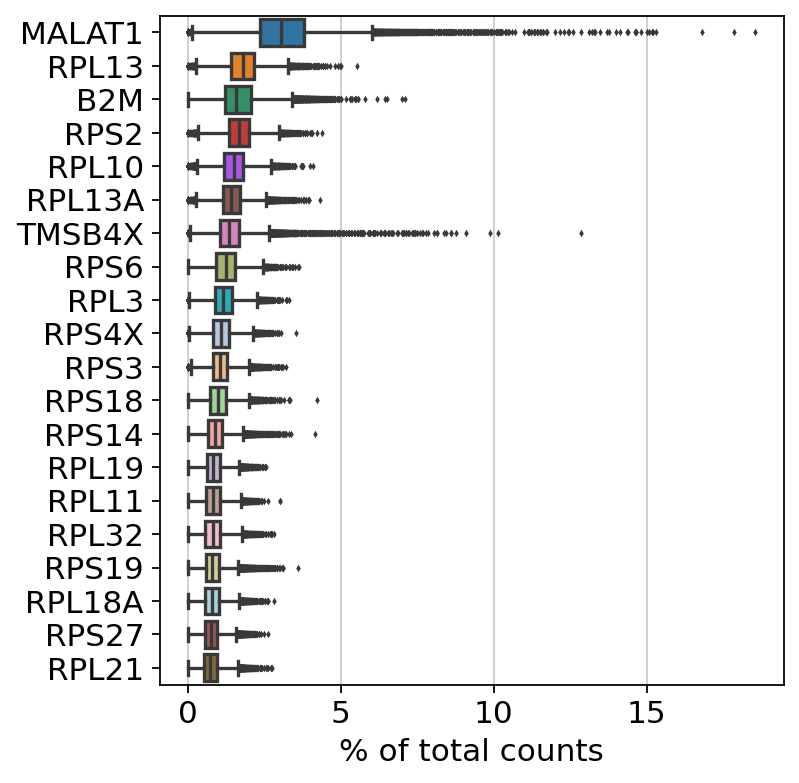

In [57]:
sc.pl.highest_expr_genes(adata, n_top=20)

We can see that the representation of the genes varies a lot. That is why we can process the data and keep only the cells or genes that verify certain conditions. For instance, we can acees all the pre-processing functions by calling `.pp`. For example, we can filter both cells and genes separately using `.filter_cells` and `.filter_genes`. The changes are made inplace by default, so that the AnnData will be changed directly. In order to keep the original data intacted, we can make a copy and modify this copy. This can be done with `.copy()` and its a tool we will be using along.

The chosen filters are the same as those in the "Zero-preserving imputation of single-cell RNA-seq data" article.
1. Cells with less than 400 genes are filtered out.
2. Genes expressed in less than 6 cells are filtered out.

In [53]:
adataFiltered = adata.copy()
sc.pp.filter_cells(adataFiltered, min_genes=400)
sc.pp.filter_genes(adataFiltered, min_cells=6)

filtered out 9810 cells that have less than 400 genes expressed
filtered out 16599 genes that are detected in less than 6 cells


In [54]:
adataFiltered

AnnData object with n_obs × n_vars = 58769 × 16139
    obs: 'celltype', 'n_genes'
    var: 'gene_ids', 'n_cells'

### 2.1. Quality Control

One can also perform easy quality control metrics all at once, for both the cells and genes. This is done using the `.pp.calculate_qc_metrics` inside the pre-processing module. If we call it just with the AnnData object inplace, some features will be added to both `.obs` and `.var`.

In [55]:
sc.pp.calculate_qc_metrics(adataFiltered, percent_top=None, log1p=False, inplace=True)

In [56]:
adataFiltered

AnnData object with n_obs × n_vars = 58769 × 16139
    obs: 'celltype', 'n_genes', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### 2.2. Normalization

In [57]:
sc.pp.normalize_total(adataFiltered, target_sum=None)
sc.pp.log1p(adataFiltered)

normalizing counts per cell
    finished (0:00:00)


In [60]:
# normalized = sc.pp.normalize_total(adataFiltered, target_sum=None, inplace=False)
# adataFiltered.layers["log1p_norm"] = sc.pp.log1p(normalized['X'], copy=True)

In [61]:
adataFiltered

AnnData object with n_obs × n_vars = 58769 × 16139
    obs: 'celltype', 'n_genes', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

We save the AnnData object before performing any dimensionality reduction or clustering, in case we want to recover the data later.

In [4]:
# adataFiltered.write_h5ad('models/adataFiltered.h5ad')
adataFiltered = sc.read_h5ad('models/adataFiltered.h5ad')

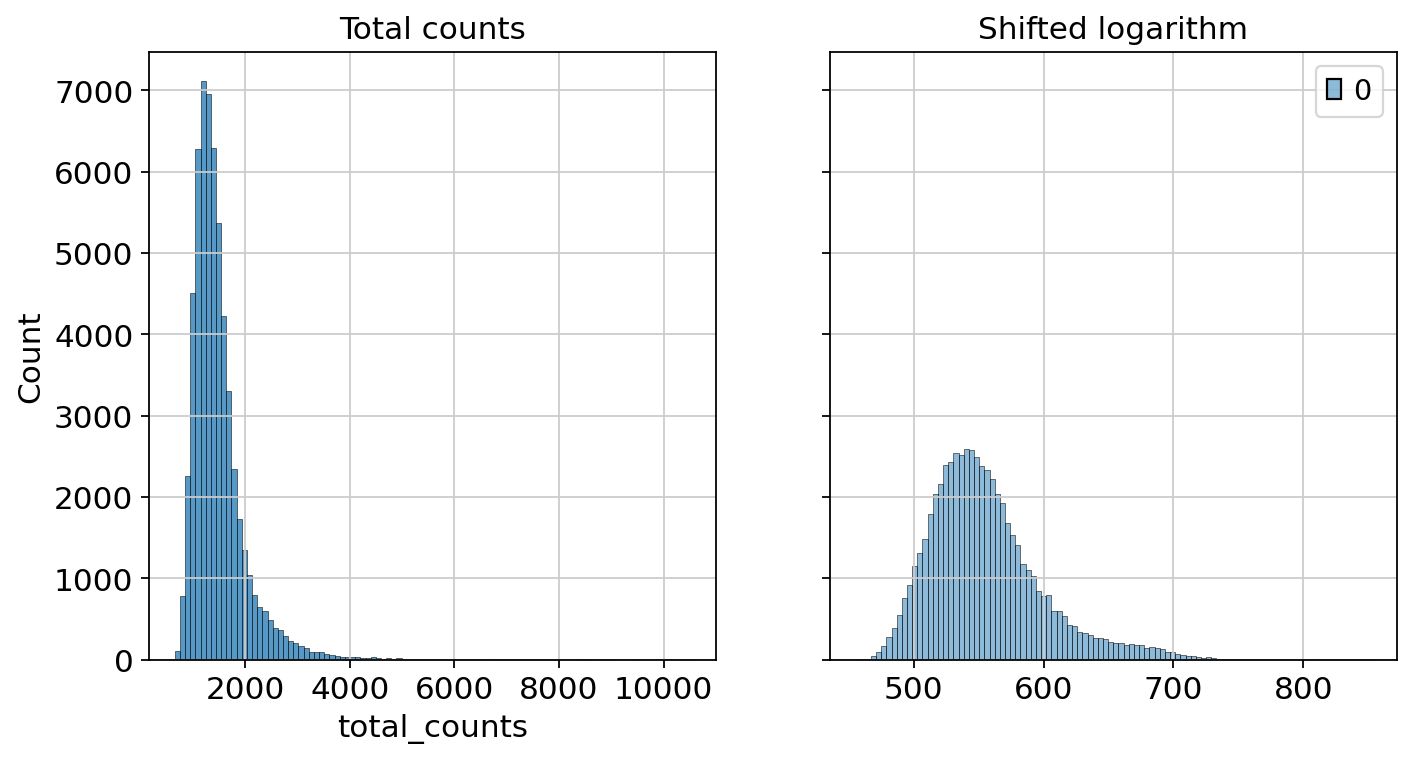

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
p1 = sns.histplot(adataFiltered.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adataFiltered.X.sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

## 3. Imputation methods

Once we have filtered and process our data, it is time to use the imputation methods, meaning that we can try to use different methods in order to recover the technical-zeros from the sparse matrix. In this case, we will compare the cluster using no imputation as well as ALRA, MAGIC and SinkHorn.

### 3.1. ALRA

In [68]:
import anndata as ad
from src.ALRA import choose_k, ALRA

In [69]:
A_norm = adataFiltered.X.toarray()
k = choose_k(A_norm)
A_alra = ALRA(A_norm, k)

In [73]:
# Calculated ALRA in 3min 13s

In [70]:
adataALRA = ad.AnnData(A_alra)
adataALRA.obs_names = adataFiltered.obs_names
adataALRA.obs['celltype'] = adataFiltered.obs['celltype']
adataALRA.var_names = adataFiltered.var_names

We save the AnnData object before performing any dimensionality reduction or clustering, in case we want to recover the data later.

In [6]:
# adataALRA.write_h5ad('models/adataALRA.h5ad')
adataALRA = sc.read_h5ad('models/adataALRA.h5ad')

### 3.2. MAGIC

In [71]:
import scprep
import magic

In [72]:
magicOP = magic.MAGIC()
A_magic = magicOP.fit_transform(adataFiltered.X.toarray(), genes='all_genes')
adataMAGIC = ad.AnnData(A_magic)

Calculating MAGIC...
  Running MAGIC on 58769 cells and 16139 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 30.60 seconds.
    Calculating KNN search...
    Calculated KNN search in 631.42 seconds.
    Calculating affinities...
    Calculated affinities in 656.53 seconds.
  Calculated graph and diffusion operator in 1318.65 seconds.
  Running MAGIC with `solver='exact'` on 16139-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 76.18 seconds.
Calculated MAGIC in 1395.21 seconds.


In [ ]:
# Calculated MAGIC in 1266.20 seconds

In [76]:
adataMAGIC.obs_names = adataFiltered.obs_names
adataMAGIC.obs['celltype'] = adataFiltered.obs['celltype']
adataMAGIC.var_names = adataFiltered.var_names

We save the AnnData object before performing any dimensionality reduction or clustering, in case we want to recover the data later.

In [7]:
# adataMAGIC.write_h5ad('models/adataMAGIC.h5ad')
adataMAGIC = sc.read_h5ad('models/adataMAGIC.h5ad')

## 4. Dimensionality reduction

In [10]:
dataList = [adataFiltered, adataALRA, adataMAGIC]

### 4.1. PCA

PCA creates a new set of uncorrelated variables, so called principle components (PCs), via an orthogonal transformation of the original dataset. The PCs are linear combinations of features in the original dataset and are ranked with decreasing order of variance to define the transformation. Through the ranking usually the first PC amounts to the largest possible variance. PCs with the lowest variance are discarded to effectively reduce the dimensionality of the data without losing information.

In order to apply it to our data, first we need to perform the method via `.tl.pap` or `.pp.pca` (they are actually the same function) and then scatter plot it using `.pl.pca`. To plot it we only need to pass the AnnData object since it will look for the components saved in `uns`, `obsm` and `varm`. In case we want the scatter plot to be colored, we can add which variable to take into account (or cell/gene).

computing PCA
    with n_comps=30
    finished (0:00:21)


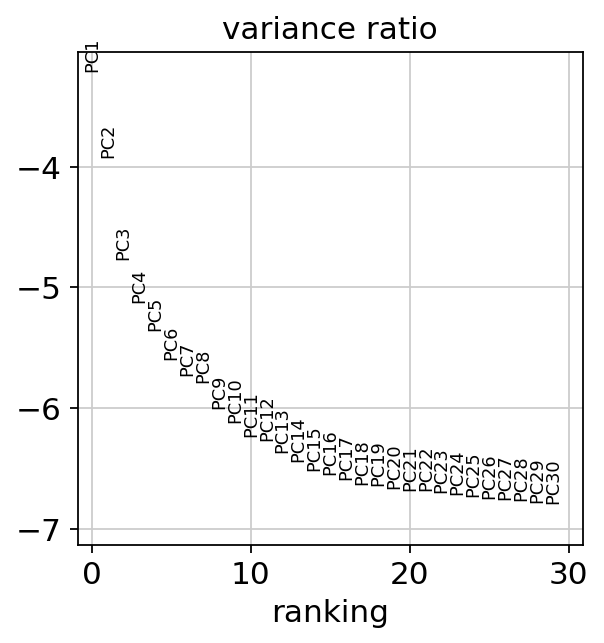

computing PCA
    with n_comps=30
    finished (0:02:21)


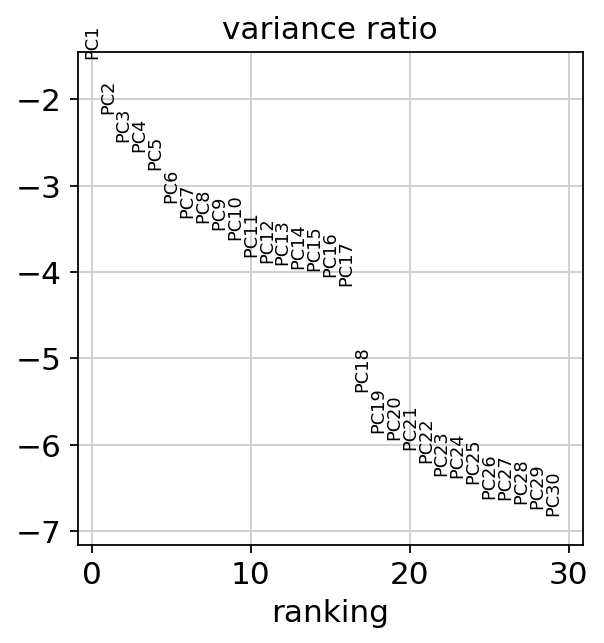

computing PCA
    with n_comps=30
    finished (0:01:54)


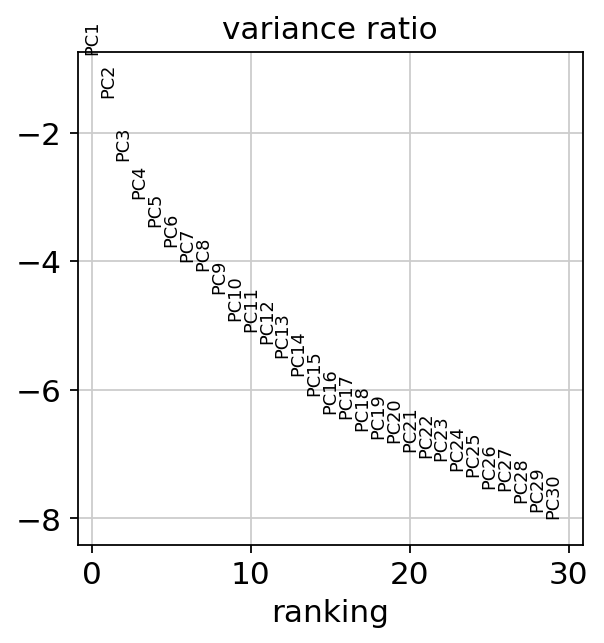

In [81]:
dataList = [adataFiltered, adataALRA, adataMAGIC]

# fig, axes = plt.subplots(nrows=1, ncols=len(dataList))
for i,data in enumerate(dataList):
    sc.pp.calculate_qc_metrics(data, percent_top=None, log1p=False, inplace=True)
    sc.tl.pca(data, svd_solver='arpack', n_comps=30)
    # sc.pl.pca(data, color='total_counts', ax=axes[i])
    sc.pl.pca_variance_ratio(data, log=True, n_pcs=30, show=True)

### 4.2. Clustering

Once one has performed the reduciton of dimension to the data, we can actually visulize it in a 2D or 3D graph. Then, clustering mehtods can be applied to this reduced data in order to group the principal components. To do so, we can use different clustering mehtods available in the `scanpy` module. Here we will show two of them, which make use of a graph structure on the data.

That is why we will need first to calculate the KNN graph on the lower-dimentional data using the `.pp.neighbors`. Appart from the data, we also need to provide the number of principal components we want to use (how many dimensions out of the total ones we want to keep). This is an important choice and it will depend on the percentage of information that each principal component carries. We can see this using the `.pl.pca_variance_ratio` function over the data.

We can perform this algorithm using the `.tl.leiden` function and by passing the reduced data with the KNN graph already performed and the resolution parameter (1 by default) which quantifies (in a way) the number of clusters. We can also pass the `neighbors_key` in case we have performed multiple KNN graphs and the `key_added` is case we use different resolutions parameters to compare them.

In [29]:
from sklearn.cluster import KMeans
import numpy as np

for i,data in enumerate(dataList):
    print(i)
    X = data.X
    if type(data.X) != np.ndarray:
        X = X.toarray()

    kmeans = KMeans(n_clusters=11, random_state=0, n_init="auto").fit(X)
    data.obs['kmeans'] = kmeans.labels_

0
1
2


In [24]:
for i,data in enumerate(dataList):
    sc.pp.neighbors(data, n_pcs=20)
    sc.tl.umap(data)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=20


/home/user/lucas-dev/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


    finished (0:00:13)


/home/user/lucas-dev/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:30)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:29)
computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=20


/home/user/lucas-dev/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


    finished (0:00:40)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:44)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:29)
computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=20


/home/user/lucas-dev/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


    finished (0:00:40)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:43)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:34)


In [82]:
for i,data in enumerate(dataList):
    sc.pp.neighbors(data, n_pcs=20)
    sc.tl.umap(data)
    sc.tl.leiden(data)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:35)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:01:04)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:34)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:57)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`

In [44]:
a = adataFiltered.obs['celltype'].unique()

In [52]:
adataFiltered.obs['kmeans'].unique().categories.tolist()

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

In [50]:
a.categories.tolist()

['CD4+ T Helper2',
 'CD4+/CD25 T Reg',
 'CD4+/CD45RA+/CD25- Naive T',
 'CD4+/CD45RO+ Memory',
 'CD8+ Cytotoxic T',
 'CD8+/CD45RA+ Naive Cytotoxic',
 'CD14+ Monocyte',
 'CD19+ B',
 'CD34+',
 'CD56+ NK',
 'Dendritic']

In [35]:
for data in dataList:
    data.obs['kmeans'] = data.obs['kmeans'].astype('string')

/home/user/lucas-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/user/lucas-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


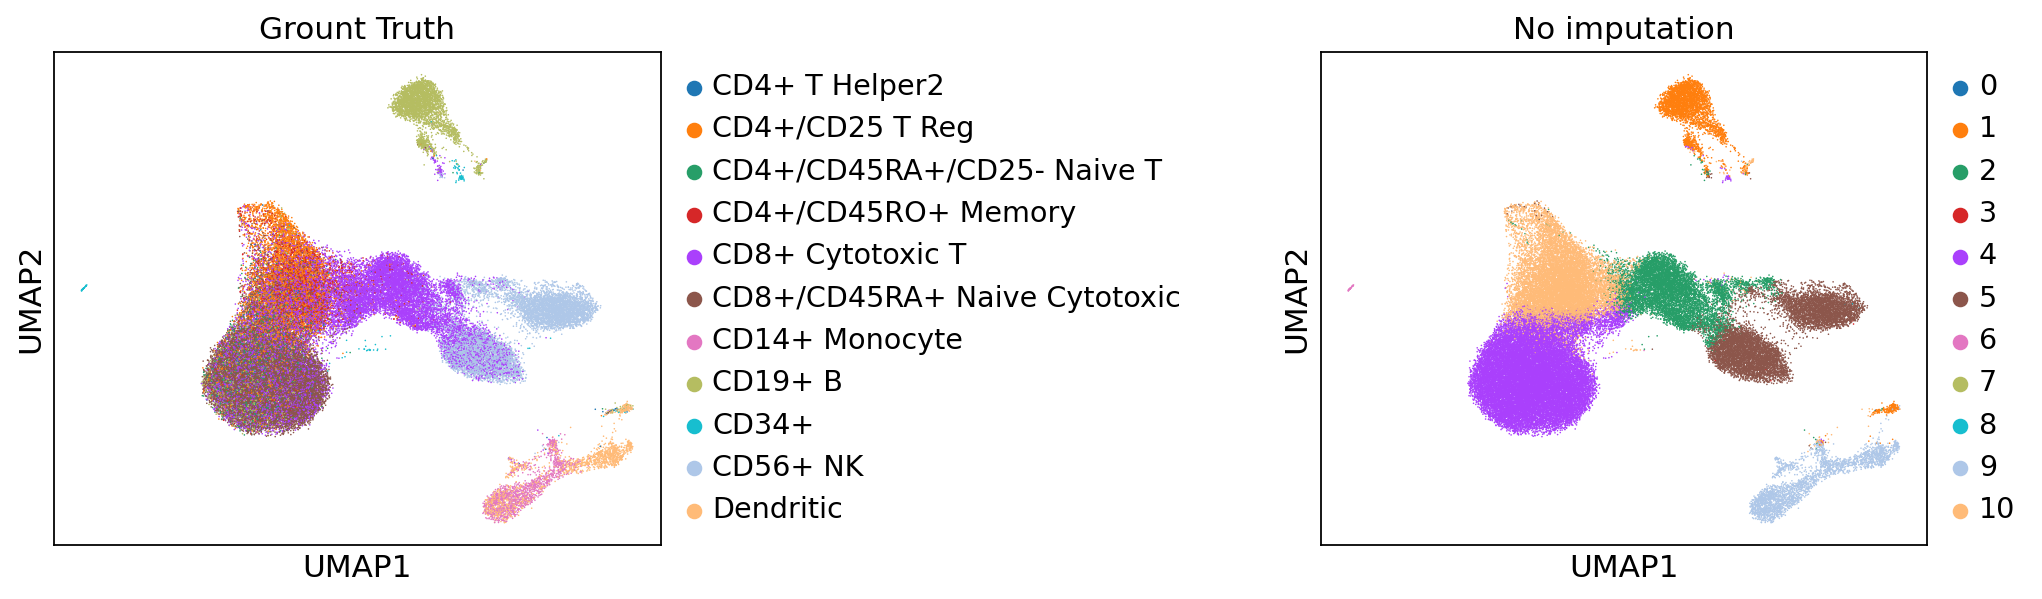

In [37]:
sc.pl.umap(adataFiltered,
           color=['celltype', 'kmeans'],
           title=['Grount Truth', 'No imputation'],
           legend_loc="right margin",
           wspace=0.9)

/home/user/lucas-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/user/lucas-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


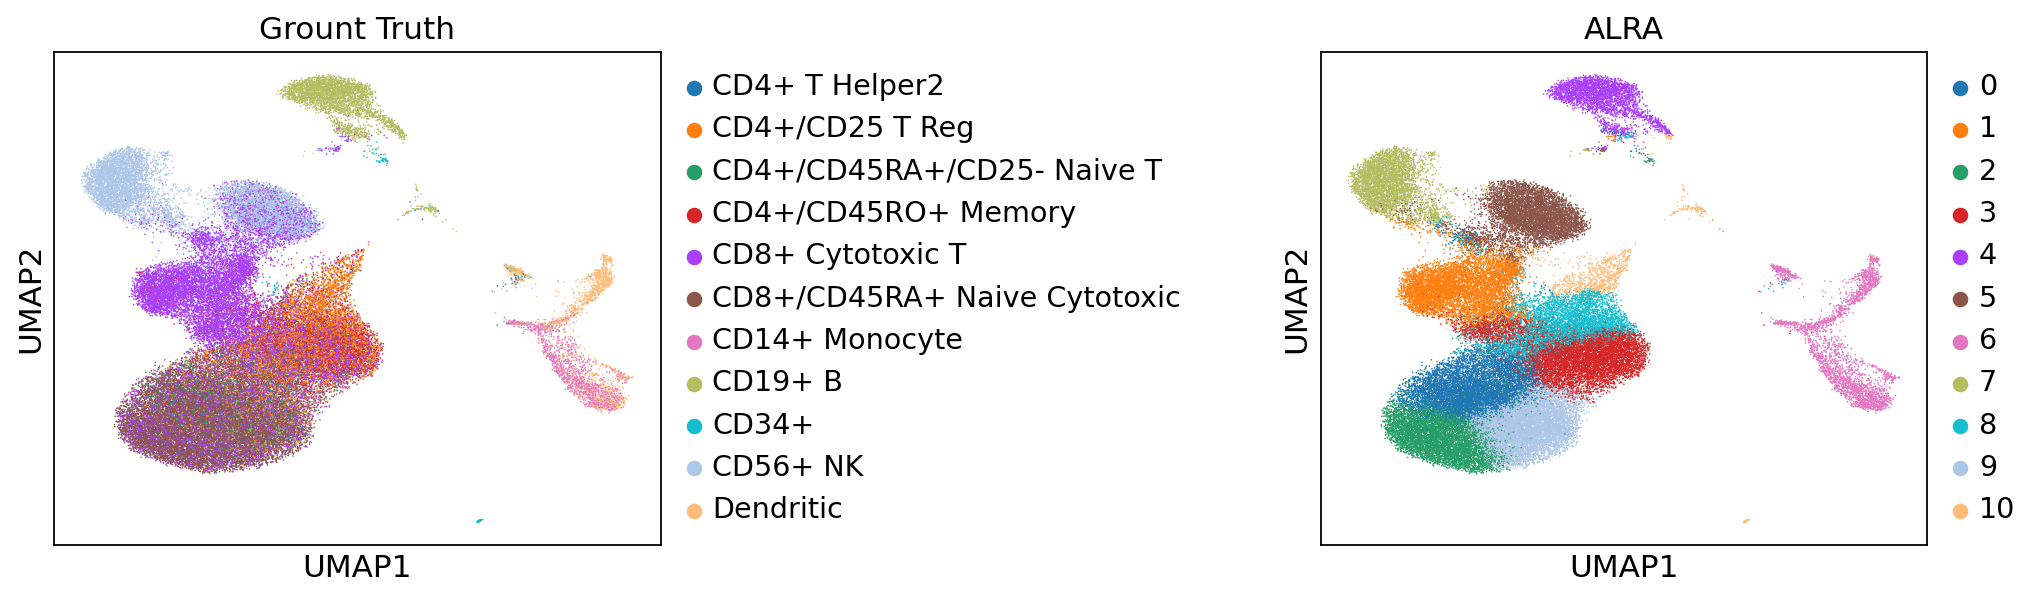

In [38]:
sc.pl.umap(adataALRA,
           color=['celltype', 'kmeans'],
           title=['Grount Truth', 'ALRA'],
           legend_loc="right margin",
           wspace=0.9)

/home/user/lucas-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/user/lucas-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


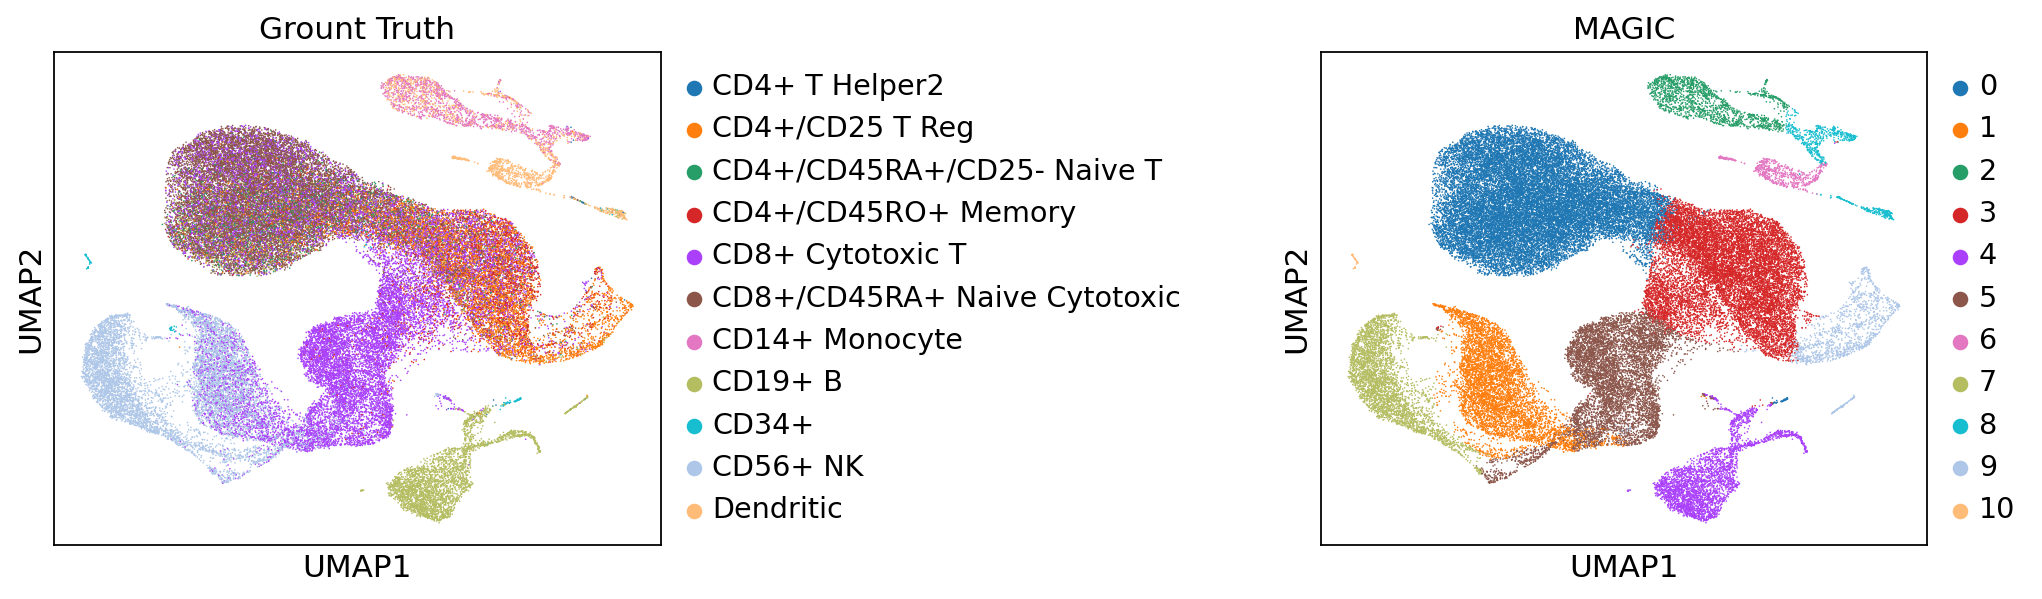

In [39]:
sc.pl.umap(adataMAGIC,
           color=['celltype', 'kmeans'],
           title=['Grount Truth', 'MAGIC'],
           legend_loc="right margin",
           wspace=0.9)

## 4. SinkHorn

In [94]:
import numpy as np
from hyperimpute.plugins.imputers import Imputers

In [ ]:
A_sink = adataFiltered.X.toarray()
A_sink[A_sink == 0] = np.nan

plugin = Imputers().get("sinkhorn")
plugin.fit_transform(A_sink)

## 5. LOT

In [90]:
from src.lot import OT1, LOT

In [ ]:
n_source_anchors = 7
n_target_anchors = 10
eps = 50

lot = LOT(n_source_anchors= n_source_anchors, n_target_anchors= n_target_anchors, epsilon=eps, epsilon_z=eps)
lot.fit(features_test_aug, features_train)